In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
import numpy as np
import scipy.sparse as sparse
import scipy
from ngsolve.la import EigenValues_Preconditioner 
import math


class ReducedBasis:

    def __init__(self, bnd='dirichlet', a=np.pi, shift_x = 0, shift_y=0):

        self.setSpace(bnd, a, shift_x, shift_y)    
        self.setInterval(0, 5)

    def reset(self):
        
        self.V = None
        self.K_red = None
        self.M_red = None
        self.P_red = None
        self.R_red = None
        self.sol = []
        self.norm = [] 
        self.residual = []
        self.dim_orig= len(self.gfu.vec)# dim of original space
        self.dim_red  = None
        self.__snapshots_updated = True
        self.__snapshots = []
        self.indices = []
        self.__first_draw = True
        
    def setDrawmode(self, mode):
        allowed_modes = ['webgui', 'default']
        
        if mode in allowed_modes:
            self.__drawmode = mode
        else:
            self.__drawmode = 'default'
        self.__first_draw = True
        
    def save(self, out_dir):
        
        print("save in folder {}", out_dir)
        
        changeable = [self.V, self.K_red, self.M_red, self.P_red, self.R_red, self.sol, self.norm, self.residual, self.beginning, self.end, self.dim_orig, self.dim_red, 
         self.__snapshots, self.__snapshots_updated, self.indices, self.bnd]

        for j in range(len(changeable)):
            np.save(out_dir+str(j), changeable[j], allow_pickle=True)
            
    def load(self, in_dir):
        
        print("load from folder {}", in_dir)

        ending = ".npy"
        self.V = np.load(in_dir+str(1)+ending, allow_pickle=True)
        self.K_red = np.load(in_dir+str(2)+ending, allow_pickle=True)
        self.M_red = np.load(in_dir+str(3)+ending, allow_pickle=True)
        self.P_red = np.load(in_dir+str(4)+ending, allow_pickle=True)
        self.R_red = np.load(in_dir+str(5)+ending, allow_pickle=True)
        self.sol = np.load(in_dir+str(6)+ending).tolist()
        self.norm = np.load(in_dir+str(7)+ending).tolist()
        self.residual = np.load(in_dir+str(8)+ending).tolist()
        self.beginning = np.load(in_dir+str(9)+ending)
        self.end = np.load(in_dir+str(10)+ending)
        self.dim_orig= np.load(in_dir+str(11)+ending)
        self.dim_red  = np.load(in_dir+str(12)+ending)
        self.__snapshots = np.load(in_dir+str(13)+ending)
        self.__snapshots_updated = np.load(in_dir+str(14)+ending)
        self.indices = np.load(in_dir+str(15)+ending).tolist()
        self.bnd = np.load(in_dir+str(16)+ending).tolist()
        


    def setSpace(self, bnd='dirichlet',  a=np.pi, shift_x=0, shift_y=0):

        ## generate mesh
        geo = netgen.geom2d.SplineGeometry()

        p1 = geo.AppendPoint (0,0)
        p2 = geo.AppendPoint (a,0)
        p3 = geo.AppendPoint (a,a)
        p4 = geo.AppendPoint (0,a)

        geo.Append (["line", p1, p2], bc = "bottom")
        geo.Append (["line", p2, p3], bc = "right")
        geo.Append (["line", p3, p4], bc = "top")
        geo.Append (["line", p4, p1], bc = "left")

        self.mesh = Mesh(geo.GenerateMesh(maxh=0.1))

        allowed_bnd = ['dirichlet', 'neumann', 'robin']
        self.bnd = bnd
        if bnd == 'dirichlet':
            self.fes = H1(self.mesh, order=5, dirichlet='top|bottom|left|right')
        elif bnd == 'neumann':
            self.fes = H1(self.mesh, order=5)
        elif bnd == 'robin':
            self.fes = H1(self.mesh, order=5,complex = True)
        else:
            print("bnd not allowed, set dirichlet")
            self.fes = H1(self.mesh, order=5, dirichlet='top|bottom|left|right')

        u,v =self.fes.TnT()

        factor = 25

        x_0 = a/2+shift_x
        y_0 = a/2+shift_y
        func = exp(-factor*((x-x_0)**2 + (y-y_0)**2))

        self.f = LinearForm(self.fes)
        self.f += func * v * dx
        self.f.Assemble()

        self.omega = Parameter(0)
        self.a = BilinearForm(self.fes)
        self.a += (grad(u)*grad(v) - self.omega*self.omega *u*v) * dx

        if self.bnd == 'robin':
            self.a += -1j*self.omega*u*v*ds
            self.r_blf = BilinearForm(self.fes)
            self.r_blf += -1j*u*v*ds
            self.r_blf.Assemble()
            rows,cols,vals = self.r_blf.mat.COO()
            self.R_orig = sparse.csr_matrix((vals,(rows,cols)))


        self.a.Assemble()


        self.gfu = GridFunction(self.fes)
        self.drawu = GridFunction(self.fes)
        
        self.k_blf = BilinearForm(self.fes)
        self.k_blf += grad(u)*grad(v)*dx
        self.pre_k = Preconditioner(self.k_blf, "multigrid")
        self.k_blf.Assemble()
        rows,cols,vals = self.k_blf.mat.COO()
        self.K_orig = sparse.csr_matrix((vals,(rows,cols)))

        self.m_blf = BilinearForm(self.fes)
        self.m_blf += u*v * dx
        self.m_blf.Assemble()

        rows,cols,vals = self.m_blf.mat.COO()
        self.M_orig = sparse.csr_matrix((vals,(rows,cols)))        

        self.reset()

    def setInterval(self, beginning, end):
        self.beginning = beginning
        self.end = end

        self.reset()


    def computeEigenvalues(self, small=True):

        if small:
            if self.__snapshots_updated:
                self.__computeRB()
                
            eig = scipy.linalg.eigh(self.K_red, self.M_red, eigvals_only=True) 
            return np.sqrt(eig)

        else:
            u = self.gfu
            r = u.vec.CreateVector()
            w = u.vec.CreateVector()
            Mu = u.vec.CreateVector()
            Au = u.vec.CreateVector()
            Mw = u.vec.CreateVector()
            Aw = u.vec.CreateVector()

            r.FV().NumPy()[:] = np.random.rand(self.fes.ndof)
            u.vec.data = Projector(self.fes.FreeDofs(), True) * r

            for i in range(20):

                Au.data = self.k_blf.mat * u.vec
                Mu.data = self.m_blf.mat * u.vec
                auu = InnerProduct(Au, u.vec)
                muu = InnerProduct(Mu, u.vec)
                # Rayleigh quotient
                lam = auu/muu
                # print (lam / (math.pi**2))
                # residual
                r.data = Au - lam * Mu
                w.data = self.pre_k.mat * r.data
                w.data = 1/Norm(w) * w
                Aw.data = self.k_blf.mat * w
                Mw.data = self.m_blf.mat * w

            print(lam /( math.pi**2) , type(lam))
        
    def setSnapshots(self, new_snapshots, reset = False):
        ## TODO: check format of snapshots
        if len(self.__snapshots) > 0 and not reset:
            print("append snapshots with {}".format(new_snapshots))
            self.__snapshots = np.append(self.__snapshots, np.array(new_snapshots))
        else:
            print("set snapshots and reset basis")
            self.__snapshots = np.array(new_snapshots)
            self.V = None
        self.__snapshots_updated = True
        tmp = self.__snapshots
        zip_to_sort = list(zip(tmp, range(len(tmp))))
        sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=False)
        self.indices = [tup[1] for tup in sorted_zip]
    
    def getSnapshots(self, sorted = True):
        return self.__snapshots[self.indices]
          
                
    def __computeRB(self):

        print("compute Reduced Basis")


        if len(self.__snapshots) == 0:
            print(""" no snapshots given, please call 'instance.setSnapshots' first""")
            return
        
        _visual = False
        if _visual:
            Draw(self.gfu)

        self.dim_red = len(self.__snapshots)
        if self.bnd == 'robin':
            V_tmp = np.zeros((self.dim_orig, self.dim_red), dtype=complex )
        else:
            V_tmp = np.zeros((self.dim_orig, self.dim_red))

        try: 
            existing_basis_len = self.V.shape[1]
            V_tmp[:,0:existing_basis_len] = self.V
            print("extending basis")
        except:
            existing_basis_len = 0


        for n in range(0+existing_basis_len, self.dim_red):
            _omega = self.__snapshots[n]
            ## compute FEM solution for parameter _omega
            self.omega.Set(_omega)
            self.a.Assemble()
            self.gfu.vec.data = self.a.mat.Inverse(self.fes.FreeDofs(), inverse="sparsecholesky") * self.f.vec

            V_tmp[:,n] = self.gfu.vec.FV().NumPy()
            self.sol += [self.gfu.vec]

                
        try:
            q, r = np.linalg.qr(V_tmp)
            self.V = V_tmp.dot(np.linalg.inv(r))
        except:
            print("Matrix is singular")

        self.K_red = np.transpose(self.V).dot(self.K_orig.dot(self.V))
        self.M_red = np.transpose(self.V).dot(self.M_orig.dot(self.V))
        self.P_red = np.transpose(self.V).dot(self.f.vec.data)

        if self.bnd == 'robin':
            self.R_red = np.transpose(self.V).dot(self.R_orig.dot(self.V))
                
        self.__snapshots_updated = False
        print("finished computing Reduced Basis")


    def computeValues(self, param, residual=True, norm=True, *args, **kwargs):

        if self.__snapshots_updated:
            self.__computeRB()
        
        self.norm = []
        self.residual = []

        ured = GridFunction(self.fes)
        tmp = GridFunction(self.fes)

        j = 0
        norm_diff = []
        for _omega in param:
            if 'time' in args:
                t3 = Timer("t3")
                t3.Start()
            
            if self.bnd == 'robin':
                Ainv = np.linalg.inv(self.K_red-_omega*_omega*self.M_red+_omega*self.R_red)
            else:
                Ainv = np.linalg.inv(self.K_red-_omega*_omega*self.M_red)

            red_sol_vec = np.matmul(Ainv, self.P_red)

            ured.vec.FV().NumPy()[:] = self.V.dot(red_sol_vec)[:]
            if 'time' in args:
                t3.Stop()
            
            if norm:
                
                nof = Integrate(ured*Conj(ured), self.mesh)
                self.norm += [nof]
            
            if residual:

                if 'numpy' in kwargs:
                    if 'timer' in args:
                        t1 = Timer("t1")
                        t1a = Timer("t1a")
                        t1b = Timer("t1b")
                        t1.Start()
                        t1a.Start()
                    
                    tmp = self.K_orig.dot(np.array(ured.vec.data)
                        ) - _omega*_omega*self.M_orig.dot(np.array(ured.vec.data)
                        ) - self.f.vec.data

                    if 'timer' in args:
                        t1a.Stop()
                        t1b.Start()

                    res2 = np.linalg.norm(tmp[self.fes.FreeDofs()])

                    if 'timer' in args:
                        t1b.Stop()
                        t1.Stop()

                        t2.AddFlops(2*self.k_blf.mat.nze)
                        t2.Start()
                                
                
                ngs_temp = self.k_blf.mat.CreateColVector()
                ngs_temp.data = self.k_blf.mat*ured.vec - _omega*_omega*self.m_blf.mat*ured.vec - self.f.vec
                if self.bnd == 'robin':
                    ngs_temp.data += _omega*self.r_blf.mat*ured.vec


                ngs_temp2 = self.k_blf.mat.CreateColVector()
                ngs_temp2.data = Projector(self.fes.FreeDofs(), True)*ngs_temp

                if 'timer' in args:
                    t2.Stop()
                
                res = Norm(ngs_temp2)
                
                self.residual += [res]

            j += 1


    def draw(self, omega):
        
        if self.__snapshots_updated:
            self.__computeRB()
        
        if self.__drawmode == 'webgui':
            from ngsolve.webgui import Draw

        elif self.__drawmode == 'default':
    
            import netgen.gui
            from ngsolve import Draw
            if self.__first_draw:
                Draw(self.drawu)
                self.__first_draw = False
        else: 
            print("unknown drawmode use instance.setDrawmode")
            return
            self.__first_draw = False

        ## TODO: solve lgs
        Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red)
        red_sol_vec = np.matmul(Ainv, self.P_red)
        
        self.drawu.vec.FV().NumPy()[:] = self.V.dot(red_sol_vec)[:]
        
        if self.__drawmode == 'webgui':
            if self.__first_draw:
                self.scene = Draw(self.drawu, self.mesh, websocket=True)
                self.__first_draw = False
            self.scene.Redraw()
        else:
            Redraw()


We define H1-FEM spaces on the square $[0, \pi] \times [0, \pi]$ with dirichlet, neumann and robin boundary values. To compute the first set of snapshot solutions we chose the parameters $\omega \in \{1, .., 20\}$. 

In [2]:
boundaries = ['dirichlet', 'neumann', 'robin']

RB_spaces = []
params = np.arange(1,20)

for bnd in boundaries:
    space = ReducedBasis(bnd=bnd, a= 1, shift_x = 0.2, shift_y=0.3)
    space.setInterval(1, 20)
    space.setSnapshots(params, reset=True)
    RB_spaces += [space]



set snapshots and reset basis
set snapshots and reset basis
set snapshots and reset basis


Now we chose an on $[1,20]$ uniformly distributed sample of $1000$ parameters and compute the norms and residuals for the corresponding solutions. 

In [3]:
random_omegas = np.sort(np.append(np.random.uniform(RB_spaces[0].beginning, RB_spaces[0].end, 1000), params))

eigenvalues = []
residuals = []
norms = []
for space in RB_spaces:
    # eig = space.computeEigenvalues()
    # eigenvalues += [eig]
    space.computeValues(random_omegas)
    residuals += [space.residual]
    norms += [space.norm]

compute Reduced Basis
finished computing Reduced Basis
compute Reduced Basis
finished computing Reduced Basis
compute Reduced Basis
finished computing Reduced Basis


Plot the norms

/home/ams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


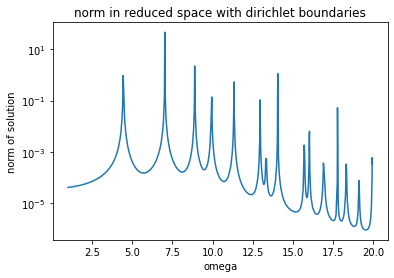

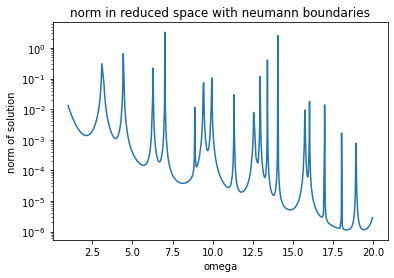

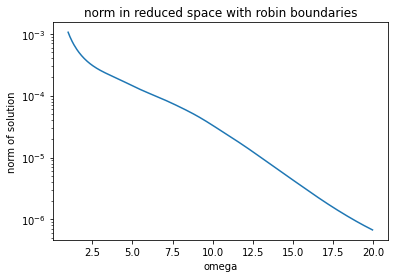

In [4]:
import matplotlib.pyplot as plt


for j in range(len(boundaries)):
    fig, ax = plt.subplots()         
    ax.plot(random_omegas, norms[j], '-', label = "norm")
    # ax.plot(eigenvalues[j], 1/2*np.ones(len(eigenvalues[j])), '*g', label = "eigenvalues")

    ax.set_xlabel("omega")
    ax.set_ylabel('norm of solution')
    ax.set_title("norm in reduced space with {} boundaries".format(boundaries[j]))
    plt.semilogy()
    # ax.set_ylim([0,10])

plt.show()


In [ ]:
Plot the residuals

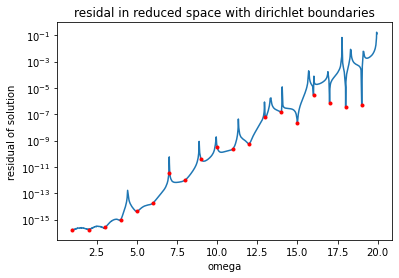

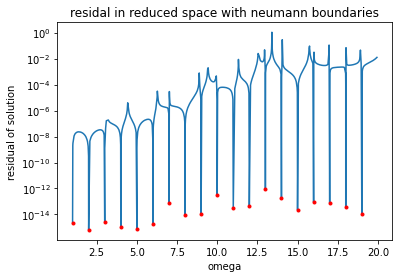

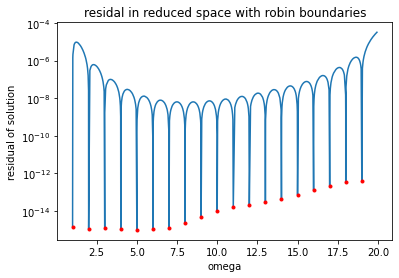

In [5]:
import matplotlib.pyplot as plt


for j in range(len(boundaries)):
    fig, ax = plt.subplots()         
    ax.plot(random_omegas, residuals[j], '-', label = "residual")
    RB_spaces[j].computeValues(RB_spaces[j].getSnapshots())
    ax.plot(RB_spaces[j].getSnapshots(), RB_spaces[j].residual, 'r.')

    ax.set_xlabel("omega")
    ax.set_ylabel('residual of solution')
    ax.set_title("residal in reduced space with {} boundaries".format(boundaries[j]))
    plt.semilogy()

plt.show()

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

##dirichlet 
space = RB_spaces[0]
space.setDrawmode("webgui")

f = lambda x: space.draw(x)
interact(f, x=widgets.FloatSlider(min=space.beginning, max=space.end, step=0.05, value=3))

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

##neumann 
space = RB_spaces[1]
space.setDrawmode("webgui")

f = lambda x: space.draw(x)
interact(f, x=widgets.FloatSlider(min=space.beginning, max=space.end, step=0.05, value=3))

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

##robin
space = RB_spaces[1]
space.setDrawmode("webgui")

f = lambda x: space.draw(x)
interact(f, x=widgets.FloatSlider(min=space.beginning, max=space.end, step=0.05, value=3))

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

space = ReducedBasis(bnd='robin', a= np.pi, shift_x = 0.2, shift_y=0.3)
space.setDrawmode("webgui")
space.setInterval(1, 20)
params = np.arange(1,20)
space.setSnapshots(params, reset=True)
space.computeValues(params)


f = lambda x: space.draw(x)
interact(f, x=widgets.FloatSlider(min=space.beginning, max=space.end, step=0.05, value=3))

In [ ]:
RBinst = ReducedBasis()
RBinst.setInterval(0,5)
params = np.arange(5)
RBinst.setSnapshots(params, reset=True)
random_omegas = np.sort(np.append(np.random.uniform(RBinst.beginning, RBinst.end, 50), params))

with TaskManager(int(1e8)):
    t2 = Timer("t2")
    RBinst.computeValues(random_omegas, norm=False)



In [ ]:
for t in Timers():
    print(t)

In [ ]:
help(TaskManager)
## HI

In [ ]:
RBinst = ReducedBasis()
RBinst.setInterval(0,5)
params = np.arange(5)
RBinst.setSnapshots(params, reset=True)
random_omegas = np.sort(np.append(np.random.uniform(RBinst.beginning, RBinst.end, 200), params))

import cProfile, pstats, io

cp = cProfile.Profile()
cp.enable()

RBinst.computeValues(random_omegas)
cp.disable()

s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(cp, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())


In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


RBinst = ReducedBasis()
RBinst.setInterval(0,5)
params = np.array(range(20))
RBinst.setSnapshots(params)

RBinst.setDrawmode("webgui")

# RBinst.draw(3)
f = lambda x: RBinst.draw(x)
interact(f, x=widgets.FloatSlider(min=RBinst.beginning, max=RBinst.end, step=0.05, value=3))

set snapshots and reset basis


interactive(children=(FloatSlider(value=3.0, description='x', max=5.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.<lambda>(x)>

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()                      
ax.plot(random_omegas, newRBinst.norm, '-', label = "norm")

#ax.plot(newRBinst.getSnapshots(), residuals_snapshots[i][newindices], '.r', label = "residual snapshot")
ax.set_xlabel("omega")
ax.set_ylabel('norm')
plt.semilogy()
ax.legend()

In [ ]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots()
out_dir = os.getcwd()+"/output/"
try:
    os.mkdir(path+out_dir)
except:
    print('no dir created')

RBinst = ReducedBasis()

beginning = RBinst.beginning
end= RBinst.end
eigenvalues = []
for j in range(beginning, end+1):
    for i in range(beginning, end+1):
        tmp = (i*i+j*j)**(1/2)
        if tmp <= end: eigenvalues += [tmp]
# print(eigenvalues)

stepsize = 0.5
first_snapshot = np.arange(RBinst.beginning,RBinst.end, stepsize)
MAX_IT = 10
snapshots = [None]*MAX_IT
norms_snapshots = [None]*MAX_IT
norms_red = [None]*MAX_IT
residuals = [None]*MAX_IT
residuals_snapshots = [None]*MAX_IT
random_omegas = np.sort(np.append(np.random.uniform(RBinst.beginning, RBinst.end, 1000), first_snapshot))

snapshots[0] = np.array(first_snapshot)
RBinst.setSnapshots(first_snapshot, reset = True)
# indices = range(len(snapshots[0]))
for i in range(0,MAX_IT):
    print("i = {}".format(i))

    RBinst.computeValues(snapshots[i])
    # norms_snapshots[i] = np.array(RBinst.norm_of_solutions_orig)
    residuals_snapshots[i]= np.array(RBinst.residual)
    
    RBinst.computeValues(random_omegas)
    norms_red[i] = np.array(RBinst.norm)
    residuals[i] = np.array(RBinst.residual)
    
    ## plot and save
    plt.cla()
    ax.plot(random_omegas, residuals[i], '-', label = "residual")
    ax.plot(snapshots[i][RBinst.indices], residuals_snapshots[i][RBinst.indices], '.r', label = "residual snapshot")
    ax.set_xlabel("omega")
    ax.set_ylabel('residual')
    ax.set_title("residual {}".format(i))
    plt.semilogy()
    ax.legend()
    plt.savefig(out_dir+"residual {}".format(i))
#     plt.plot()

    plt.cla()
    ax.plot(random_omegas, norms_red[i], '-', label = "norm")
    ax.plot(eigenvalues, np.ones(len(eigenvalues)), '.', label="eigenvalues")
    ax.set_xlabel("omega")
    ax.set_ylabel('norm of reduced solution')
    ax.set_title("norm reduced solution {}".format(i))
    plt.semilogy()
    # ax.legend()
    plt.savefig(out_dir+"norm_red {}".format(i))
#     plt.plot()

    plt.cla()
    ax.plot(snapshots[i][RBinst.indices], norms_snapshots[i][RBinst.indices], '-', label = "norm")
    ax.set_xlabel("omega")
    ax.set_ylabel('norm of snapshot solution')
    ax.set_title("norm snapshot solution {}".format(i))
    plt.semilogy()
    # ax.legend()
    plt.savefig(out_dir+"norm_snap {}".format(i))
#     plt.plot()
    

    if i < MAX_IT-1:
        
        ## sort by residual
        tmp = residuals[i]
        zip_to_sort = list(zip(tmp, range(len(tmp))))
        sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
        tmp_ind = [tup[1] for tup in sorted_zip]
        for j in range(len(RBinst.indices)):
            if not (random_omegas[tmp_ind[j]] in snapshots[i]):
                max_omega = random_omegas[tmp_ind[j]]
                snapshots[i+1] = np.append(snapshots[i], max_omega)
                RBinst.setSnapshots(max_omega)
                break

        # tmp = snapshots[i+1]
        # zip_to_sort = list(zip(tmp, range(len(tmp))))
        # sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=False)
        # indices = [tup[1] for tup in sorted_zip]

print('finished')


In [ ]:
RBinst.save("./saved_RBinst_/")

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()                      
ax.plot(random_omegas, newRBinst.norm, '-', label = "norm")

# ax.plot(snapshots[i][indices], residuals_snapshots[i][indices], '.r', label = "residual snapshot")
ax.set_xlabel("omega")
ax.set_ylabel('norm')
plt.semilogy()
ax.legend()
